In [6]:
import gymnasium as gym
from matplotlib import pyplot as plt
import numpy as np
import pickle

## Boltzmann Policy

In [7]:
# Defining the softmax function
def softmax(values):
    # Computing element wise exponential value
    exp_values = np.exp(values)

    # Computing sum of these values
    exp_values_sum = np.sum(exp_values)

    # Returing the softmax output.
    return exp_values/exp_values_sum

In [8]:
def frozenLakeEpsilonGreedy(render, isTraining, episodes, learning_rate_a, discount_factor_g, temperature, temperature_decay_rate):
    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True, render_mode='human' if render else None)

    if isTraining:
        q = np.zeros((env.observation_space.n, env.action_space.n))
    else:
        f = open('frozen_lake8x8.pk1', 'rb')
        q = pickle.load(f)
        f.close()

    rng = np.random.default_rng()

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False

        while(not terminated and not truncated):
            action_values = q[state, :]
            value = (action_values - np.nanmax(action_values))/temperature
            probs = softmax(value)
            action = np.random.choice(len(probs), p=probs)

            new_state, reward, terminated, truncated, _ = env.step(action)

            if isTraining:
                q[state, action] = q[state, action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state,:]) - q[state, action]
                )

            state = new_state

        temperature = max(temperature - temperature_decay_rate, 0)

        if temperature == 0:
            learning_rate_a = 0.0001

        if reward == 1:
            rewards_per_episode[i] = 1

    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])

    return sum_rewards, q

# Save function to save the model
def save(q_tabel, sum_rewards):
    # Plotting
    plt.plot(sum_rewards)
    plt.savefig('frozen_lake8x8.png')  # Save plot to a file

    # Save Q-table to a file
    f = open("frozen_lake8x8.pk1","wb")
    pickle.dump(q_tabel, f)
    f.close()

# Plot function to plot the rewards graph
def plot(sum_rewards):
    plt.plot(
        sum_rewards)


In [9]:
sum_rewards, q = frozenLakeEpsilonGreedy(
    render=False,
    isTraining=True,
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    temperature=1.0,
    temperature_decay_rate=0.0001
)

plot(
    sum_rewards=sum_rewards)
plt.legend()
plt.show()

TypeError: unhashable type: 'numpy.ndarray'

## Epsilon-Greedy algorithm

### Epsilon-Greedy algorithm

The epsilon-greedy algorithm is a strategy used to balance between exploration and exploitation in reinforcement learning. Exploration involves taking actions to gather more information about the environment, while exploitation involves selecting actions that are believed to yield the highest immediate reward based on current knowledge. However, relying solely on exploitation may lead to suboptimal decisions. Epsilon-greedy addresses this dilemma by randomly selecting between exploration and exploitation, with the parameter epsilon determining the probability of exploration. This approach allows the agent to primarily exploit known information while occasionally exploring new options to improve its understanding of the environment.
<br><br>
In this code snippet, the epsilon-greedy algorithm is implemented to balance between exploration and exploitation in decision-making. Initially, a random number is generated, and if this number is less than the epsilon value (typically set to 1 by default), the agent takes a random action, facilitating exploration of the environment. Conversely, if the generated number exceeds epsilon, the agent selects an action based on the Q-values, prioritizing exploitation of known information to maximize immediate rewards.

```python
        # Exploration vs Exploitation trade-off
        if isTraining and rng.random() < epsilon:
            action = env.action_space.sample()  # Random action
        else:
            action = np.argmax(q[state,:])  # Greedy action based on Q-value
```
<br>

Following the epsilon-greedy strategy, epsilon is subsequently reduced using the epsilon_decay_rate parameter. This reduction in epsilon over time gradually shifts the agent's behavior towards exploitation, as exploration becomes less frequent with each iteration. By decreasing epsilon, the agent becomes increasingly reliant on its learned Q-values to make decisions.

```python
        # Epsilon decay
        epsilon = max(epsilon - epsilon_decay_rate, 0)

```

<strong>Source:</strong><br>
GfG. (2023, January 10). Epsilon-Greedy algorithm in reinforcement learning. GeeksforGeeks. https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/

### Parameters

<strong>render</strong><br>
The parameter "render" determines whether the game is rendered during training and is stored as a boolean value. When set to False, the game will not be rendered, resulting in a faster training process. However, this also means that the training progress is not visible during the training session.


<strong>isTraining</strong><br>
The parameter "isTraining" determines whether the game is actively training a model or if it is using a previously trained model to perform a task. When set to True, the game is in the training mode, actively training a model. Conversely, when set to False, the game utilizes the last trained model to perform the task without further training.


<strong>episodes</strong><br>
This parameter, referred to as "episodes," dictates the number of learning iterations the model will undergo. It essentially defines the total number of training iterations or epochs the model will execute during the learning process.


<strong>learning_rate_a</strong><br>
This is the learning rate, denoted by the symbol α in the Q-learning algorithm. It determines to what extent the newly acquired information overrides the existing information in the Q-table.


<strong>discount_factor_g</strong><br>
This is the discount factor, denoted by the symbol γ in the Q-learning algorithm. It represents the importance of future rewards relative to immediate rewards. It discounts the value of future rewards that are further in time.


<strong>epsilon</strong><br>
Epsilon (ε) is a parameter that controls the exploration vs. exploitation trade-off in reinforcement learning. A high epsilon value encourages more exploration, meaning the agent chooses random actions more frequently, while a low epsilon value encourages exploitation, meaning the agent relies more on its learned Q-values to select actions.


<strong>epsilon_decay_rate</strong><br>
This parameter determines the rate at which epsilon decreases over time. Typically, epsilon starts at a relatively high value and gradually decays towards zero as the agent learns more about the environment.

### Functions

In [2]:
# Model using the Epsilon Greedy algorithm
def frozenLakeEpsilonGreedy(render, isTraining, episodes, learning_rate_a, discount_factor_g, epsilon, epsilon_decay_rate):
    # Environment setup
    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True, render_mode='human' if render else None)

    if isTraining:
        # Q-table initialization
        q = np.zeros((env.observation_space.n, env.action_space.n))
    else:
        f = open('frozen_lake8x8.pk1', 'rb')
        q = pickle.load(f)
        f.close()

    # Random number generator
    rng = np.random.default_rng()

    # Rewards per episode initialization
    rewards_per_episode = np.zeros(episodes)

    # Loop over episodes
    for i in range(episodes):
        # Reset environment
        state = env.reset()[0]
        terminated = False
        truncated = False

        # Episode loop
        while(not terminated and not truncated):
            # Exploration vs Exploitation trade-off
            if isTraining and rng.random() < epsilon:
                action = env.action_space.sample()  # Random action
            else:
                action = np.argmax(q[state,:])  # Greedy action based on Q-values

            # Take a step in the environment
            new_state, reward, terminated, truncated, _ = env.step(action)

            if isTraining:
                # Q-value update using Q-learning equation
                q[state, action] = q[state, action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state,:]) - q[state, action]
                )

            # Transition to the new state
            state = new_state

        # Epsilon decay
        epsilon = max(epsilon - epsilon_decay_rate, 0)

        # Learning rate decay
        if epsilon == 0:
            learning_rate_a = 0.0001

        # Store rewards for this episode
        if reward == 1:
            rewards_per_episode[i] = 1

    # Close the environment
    env.close()

    # Cumulative sum of rewards over 1000 episodes
    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])

    return sum_rewards, q

# Save function to save the model
def save(q_tabel, sum_rewards):
    # Plotting
    plt.plot(sum_rewards)
    plt.savefig('frozen_lake8x8.png')  # Save plot to a file

    # Save Q-table to a file
    f = open("frozen_lake8x8.pk1","wb")
    pickle.dump(q_tabel, f)
    f.close()

# Plot function to plot the rewards graph
def plot(sum_rewards, label:str):
    plt.plot(
        sum_rewards, 
        label=label)


### Epsilon vs Reward

I have rewritten the method to focus solely on essential parameters and removed unnecessary ones such as "render" and "is_training". Default values have been set for parameters to simplify function calls. Additionally, I adjusted the results by dividing the sum results by 100, enabling values to range between 0 and 1 instead of 0 and 100. This modification facilitates plotting of epsilons and sum of rewards on the same graph.

In [17]:
# Model using the Epsilon Greedy algorithm
def frozenLakeEpsilonGreedyEpsilonVsReward(
        episodes=15000, 
        learning_rate_a=0.8, 
        discount_factor_g=0.9, 
        epsilon=1, 
        epsilon_decay_rate=0.0001):
    # Epsilons storage
    epsilons = []

    # Environment setup
    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True, render_mode=None)

    q = np.zeros((env.observation_space.n, env.action_space.n))

    # Random number generator
    rng = np.random.default_rng()

    # Rewards per episode initialization
    rewards_per_episode = np.zeros(episodes)

    # Loop over episodes
    for i in range(episodes):
        # Reset environment
        state = env.reset()[0]
        terminated = False
        truncated = False

        # Episode loop
        while(not terminated and not truncated):
            # Exploration vs Exploitation trade-off
            if rng.random() < epsilon:
                action = env.action_space.sample()  # Random action
            else:
                action = np.argmax(q[state,:])  # Greedy action based on Q-values

            # Take a step in the environment
            new_state, reward, terminated, truncated, _ = env.step(action)

            # Q-value update using Q-learning equation
            q[state, action] = q[state, action] + learning_rate_a * (
                reward + discount_factor_g * np.max(q[new_state,:]) - q[state, action]
            )

            # Transition to the new state
            state = new_state

        # Epsilon decay
        epsilon = max(epsilon - epsilon_decay_rate, 0)
        epsilons.append(epsilon)

        # Learning rate decay
        if epsilon == 0:
            learning_rate_a = 0.0001

        # Store rewards for this episode
        if reward == 1:
            rewards_per_episode[i] = 1

    # Close the environment
    env.close()

    # Cumulative sum of rewards over 1000 episodes
    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])/100

    return sum_rewards, epsilons

By plotting both the sum of rewards and the epsilons, we observe a significant increase in the sum of rewards once the epsilon reaches 0. This sharp increase occurs because the algorithm consistently selects the best q-value instead of opting for a random choice. With an epsilon value of 0, exploration ceases, compelling the agent to always choose the optimal path.
<br><br>
<strong>Sources:</strong><br>
Does RL methods converge with epsilon = 0? (n.d.). Stack Overflow. https://stackoverflow.com/questions/58343511/does-rl-methods-converge-with-epsilon-0

In [29]:
sum_rewards, epsilons = frozenLakeEpsilonGreedyEpsilonVsReward()
sum_rewardsHigh, epsilonsHigh = frozenLakeEpsilonGreedyEpsilonVsReward(epsilon_decay_rate=0.0005)

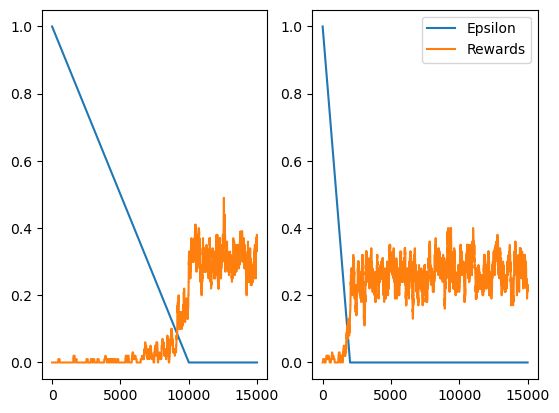

In [30]:
fig, axs = plt.subplots(1,2)

axs[0].plot(
    epsilons,
    label='Epsilon')
axs[0].plot(
    sum_rewards,
    label='Rewards')
axs[1].plot(
    epsilonsHigh,
    label='Epsilon')
axs[1].plot(
    sum_rewardsHigh,
    label='Rewards')

plt.legend()

### Epsilon experiment

<strong>Question:</strong><br>
<em>What is the best Epsilon value to balanse the exploration and exploitation?</em>

<strong>Experiment:</strong><br>
The experimentation involves varying the epsilon value, which dictates the balance between exploration and exploitation in the reinforcement learning model. By adjusting the start value of epsilon, different exploration-exploitation trade-offs can be evaluated. The code snippet provided iterates over multiple epsilon values to train the RL model, and the resulting rewards are plotted for analysis. It's important to note that a reward outcome of 0 signifies that the agent never found the reward, potentially indicating insufficient exploration. To mitigate the impact of such occurrences, the experiment will be conducted 10 times to ensure robustness in the results and to account for variations in the agent's learning process across different epsilon values.

<strong>Results:</strong><br>
<table>
  <tr>
    <th>Iteration</th>
    <th>eps: 2</th>
    <th>eps: 1</th>
    <th>eps: 0.9</th>
    <th>eps: 0.8</th>
    <th>eps: 0.7</th>
  </tr>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>40</td>
    <td>20</td>
    <td>0</td>
    <td>50</td>
  </tr>
  <tr>
    <td>2</td>
    <td>1</td>
    <td>0</td>
    <td>30</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>3</td>
    <td>1</td>
    <td>40</td>
    <td>40</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>4</td>
    <td>1</td>
    <td>50</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>5</td>
    <td>1</td>
    <td>31</td>
    <td>1</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>6</td>
    <td>1</td>
    <td>15</td>
    <td>0</td>
    <td>50</td>
    <td>0</td>
  </tr>
  <tr>
    <td>7</td>
    <td>2</td>
    <td>40</td>
    <td>20</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>8</td>
    <td>3</td>
    <td>45</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>9</td>
    <td>1.5</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>10</td>
    <td>1</td>
    <td>60</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
</table>
<br>

<strong>Conclusion:</strong><br>
<table>
    <tr>
        <th>
        <th>eps: 2</th>
        <th>eps: 1</th>
        <th>eps: 0.9</th>
        <th>eps: 0.8</th>
        <th>eps: 0.7</th>
    </tr>
    <tr>
        <td>Average</td>
        <td>1,35</td>
        <td>32.1</td>
        <td>11.1</td>
        <td>5.0</td>
        <td>5.0</td>
    </tr>
    <tr>
        <td>Highest value</td>
        <td>3.0</td>
        <td>60.0</td>
        <td>40.0</td>
        <td>50.0</td>
        <td>50.0</td>
    <tr>
        <td>Amount of 0</td>
        <td>0</td>
        <td>2</td>
        <td>5</td>
        <td>9</td>
        <td>9</td>
    </tr>
</table>

After analyzing the values presented in the table above, it is evident that an epsilon value of 1 yields the most favorable results. This conclusion is drawn based on several factors: the highest average reward, the highest reward value achieved, and comparatively fewer instances of zero rewards. Given the context of the problem scenario, specifically in the Frozen Lake environment utilizing the epsilon-greedy algorithm, an epsilon value of 1 emerges as the optimal choice.

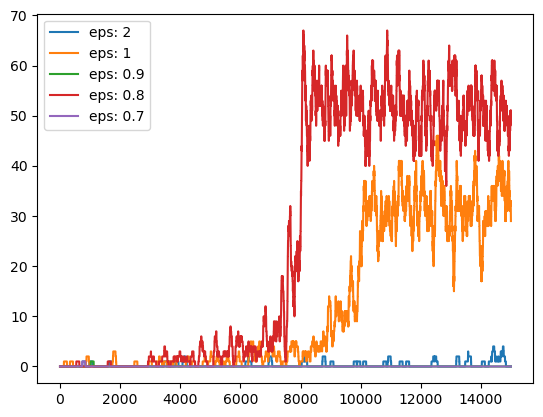

In [3]:
epsilons = [2, 1, 0.9, 0.8, 0.7]
for epsilon in epsilons:
    sum_rewards, _ = frozenLakeEpsilonGreedy(
        render=False,
        isTraining=True,
        episodes=15000,
        learning_rate_a=0.8,
        discount_factor_g=0.9,
        epsilon=epsilon,
        epsilon_decay_rate=0.0001
    )

    plot(
        sum_rewards=sum_rewards,
        label=f'eps: {epsilon}')
plt.legend()
plt.show()

### Epsilon decay rate experiment

<strong>Question:</strong><br>
<em>What is the best Epsilon decay rate to balanse the exploration and exploitation?</em>

<strong>Experiment:</strong><br>
The experimentation entails adjusting the epsilon decay rate to ascertain the optimal balance between exploration and exploitation for the agent. The epsilon decay rate is the parameter responsible for reducing the epsilon value after each episode until it reaches 0, as depicted in the code snippet provided below.

```python
        # Epsilon decay
        epsilon = max(epsilon - epsilon_decay_rate, 0)
```
Given that the epsilon greedy algorithm relies on the epsilon value to determine whether to choose a random action or an action based on learned values, the significance of this parameter cannot be overstated. A lower epsilon value increases the likelihood of the agent selecting a learned action over a random one. It is intriguing to investigate under which conditions the agent performs better: with a low epsilon or a higher one.

<strong>Results:</strong><br>
The results of this experiment are characterized by two crucial metrics: the increase in the sum of rewards over time, and the average sum of rewards at the end of the experiment. The table labeled "up" contains data indicating episodes where there was a significant increase in the sum of rewards. Conversely, the "ended" table stores the average sum of rewards at the conclusion of the experiment, specifically after notable upward changes in the sum of rewards occurred.<br>

<strong>Ended Values</strong>
<table>
  <tr>
    <th>Iteration</th>
    <th>Decay Rate 0.0001</th>
    <th>Decay Rate 0.0002</th>
    <th>Decay Rate 0.0003</th>
    <th>Decay Rate 0.0004</th>
    <th>Decay Rate 0.0005</th>
  </tr>
  <tr>
    <td>1</td>
    <td>40</td>
    <td>40</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>2</td>
    <td>40</td>
    <td>40</td>
    <td>0</td>
    <td>25</td>
    <td>0</td>
  </tr>
  <tr>
    <td>3</td>
    <td>45</td>
    <td>25</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>4</td>
    <td>20</td>
    <td>0</td>
    <td>32</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>5</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>35</td>
  </tr>
  <tr>
    <td>6</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>7</td>
    <td>25</td>
    <td>30</td>
    <td>0</td>
    <td>25</td>
    <td>0</td>
  </tr>
  <tr>
    <td>8</td>
    <td>40</td>
    <td>10</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>9</td>
    <td>0</td>
    <td>0</td>
    <td>35</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>10</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>20</td>
  </tr>
</table>

<strong>Up Values</strong>
<table>
  <tr>
    <th>Iteration</th>
    <th>Decay Rate 0.0001</th>
    <th>Decay Rate 0.0002</th>
    <th>Decay Rate 0.0003</th>
    <th>Decay Rate 0.0004</th>
    <th>Decay Rate 0.0005</th>
  </tr>
  <tr>
    <td>1</td>
    <td>10000</td>
    <td>5000</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
  </tr>
  <tr>
    <td>2</td>
    <td>10000</td>
    <td>5000</td>
    <td>no</td>
    <td>2500</td>
    <td>no</td>
  </tr>
  <tr>
    <td>3</td>
    <td>10000</td>
    <td>4900</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
  </tr>
  <tr>
    <td>4</td>
    <td>10000</td>
    <td>no</td>
    <td>3000</td>
    <td>no</td>
    <td>no</td>
  </tr>
  <tr>
    <td>5</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
    <td>2000</td>
  </tr>
  <tr>
    <td>6</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
  </tr>
  <tr>
    <td>7</td>
    <td>10000</td>
    <td>5000</td>
    <td>no</td>
    <td>2000</td>
    <td>no</td>
  </tr>
  <tr>
    <td>8</td>
    <td>10000</td>
    <td>5000</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
  </tr>
  <tr>
    <td>9</td>
    <td>no</td>
    <td>no</td>
    <td>3000</td>
    <td>no</td>
    <td>no</td>
  </tr>
  <tr>
    <td>10</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
    <td>no</td>
    <td>4500</td>
  </tr>
</table>
<br>

<strong>Conclusion</strong>
<table>
  <tr>
    <th></th>
    <th>Decay Rate 0.0001</th>
    <th>Decay Rate 0.0002</th>
    <th>Decay Rate 0.0003</th>
    <th>Decay Rate 0.0004</th>
    <th>Decay Rate 0.0005</th>
  </tr>
  <tr>
    <td>Average ended value</td>
    <td>21,0</td>
    <td>14,5</td>
    <td>6,7</td>
    <td>5,0</td>
    <td>5,5</td>
  </tr>
  <tr>
    <td>Higest ended value</td>
    <td>45</td>
    <td>40</td>
    <td>35</td>
    <td>25</td>
    <td>35</td>
  </tr>
  <tr>
    <td>Average up value</td>
    <td>6000,0</td>
    <td>2490,0</td>
    <td>600,0</td>
    <td>450,0</td>
    <td>650,0</td>
  </tr>
  <tr>
    <td>Higest up value</td>
    <td>10000</td>
    <td>5000</td>
    <td>3000</td>
    <td>2500</td>
    <td>4500</td>
  </tr>
  <tr>
    <td>Amount of 0</td>
    <td>4</td>
    <td>5</td>
    <td>8</td>
    <td>8</td>
    <td>8</td>
  </tr>
</table>

Based on the analysis presented in the conclusion table, it is evident that a decay rate of 0.0001 yields the most favorable results in terms of reward outcomes. However, it is important to note that this decay rate requires a longer training duration, as indicated by the average "up" value. Conversely, a decay rate of 0.0002 exhibits lower reward outcomes but significantly shorter training times. The optimal choice between these options depends on the prioritization of speed versus reward attainment. In this context, where reward achievement holds greater significance, a decay rate of 0.0001 emerges as the preferred option.

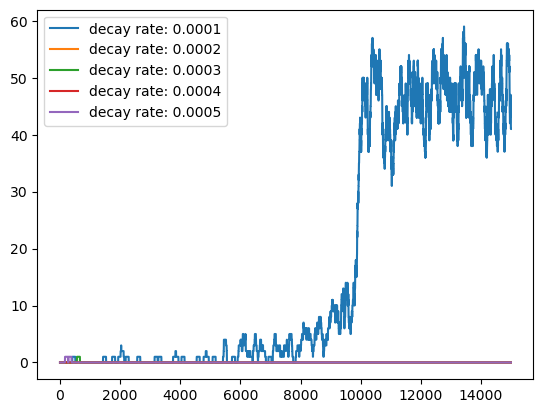

In [4]:
epsilons_decay_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
for epsilon_decay_rate in epsilons_decay_rates:
    sum_rewards, _ = frozenLakeEpsilonGreedy(
        render=False,
        isTraining=True,
        episodes=15000,
        learning_rate_a=0.8,
        discount_factor_g=0.9,
        epsilon=1,
        epsilon_decay_rate=epsilon_decay_rate
    )

    plot(
        sum_rewards=sum_rewards,
        label=f'decay rate: {epsilon_decay_rate}')
plt.legend()
plt.show()

### Best result

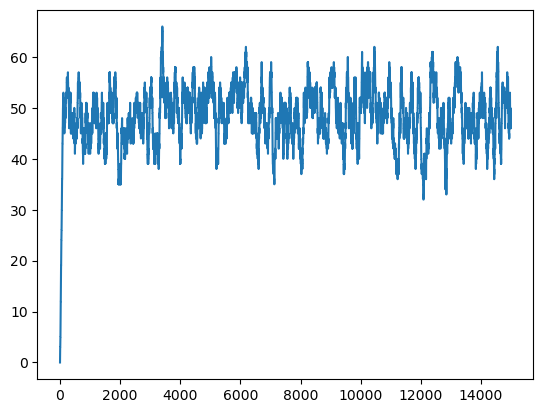

In [6]:
sum_rewards, q_tabel = frozenLakeEpsilonGreedy(
    render=False,
    isTraining=False,
    episodes=15000,
    learning_rate_a=0.8,
    discount_factor_g=0.9,
    epsilon=1,
    epsilon_decay_rate=0.0001
)

save(
    sum_rewards=sum_rewards,
    q_tabel=q_tabel
)